In [1]:
using JuliaFEM

using JuliaFEM.Core: Node, Element, Seg2, Tri3, Quad4
using JuliaFEM.Core: Problem, FieldProblem, BoundaryProblem, Dirichlet, Elasticity, Mortar
using JuliaFEM.Core: Solver, SparseMatrixCOO
using JuliaFEM.Core: get_elements, update!, calculate_normal_tangential_coordinates!,
get_connectivity, get_field_assembly, get_boundary_problems, handle_overconstraint_error!

using JuliaFEM.Preprocess: parse_aster_med_file

import JuliaFEM.Core: solve_linear_system

using PyPlot

ENV["COLUMNS"] = 300

300

In [2]:
function plot_it(field_problem, scaling_factor=1, time=0.0; show_undeformed=true,
    show_deformed=true, show_node_ids=true, equal_axis=true, xmin=-1000, ymin=-1000, xmax=1000, ymax=1000)

    function in_window(X)
        xmin < X[1] < xmax || return false
        ymin < X[2] < ymax || return false
        return true
    end

    for element in field_problem.elements
        conn = get_connectivity(element)
        X = element("geometry", time)
        
        u = element("displacement", time)
        x = X + scaling_factor*u

        if show_undeformed
            # undeformed
            for i=1:length(X)
                in_window(X[i]) || continue
                px1 = X[i][1]
                py1 = X[i][2]
                px2 = X[mod(i,length(X))+1][1]
                py2 = X[mod(i,length(X))+1][2]
                PyPlot.plot([px1, px2], [py1, py2], "k-", alpha=0.5, label="undeformed")
            end
        end

        if show_deformed
            # deformed
            for i=1:length(x)
                in_window(x[i]) || continue
                px1 = x[i][1]
                py1 = x[i][2]
                px2 = x[mod(i,length(x))+1][1]
                py2 = x[mod(i,length(x))+1][2]
                PyPlot.plot([px1, px2], [py1, py2], "g-", alpha=0.5, label="deformed")
            end
        end

        if show_node_ids
            for (i, c) in enumerate(conn)
                in_window(x[i]) || continue
                PyPlot.text(x[i][1], x[i][2], "$c")
            end
        end
        
    end

    if equal_axis
        PyPlot.axis("equal")
    end
    #PyPlot.grid()

end

using JuliaFEM.Core: project_from_master_to_slave, project_from_slave_to_master

function plot_normals(contact_problem, time, scale=3)
    for element in get_elements(contact_problem)
        X1 = element("geometry", [-1.0], time)
        X2 = element("geometry", [ 1.0], time)
        n1 = element("normal-tangential coordinates", [-1.0], time)
        n2 = element("normal-tangential coordinates", [ 1.0], time)
        plot([X1[1], X1[1]+scale*n1[1]], [X1[2], X1[2]+scale*n1[2]], "-b")
        plot([X2[1], X2[1]+scale*n2[1]], [X2[2], X2[2]+scale*n2[2]], "-b")
    end
end

function plot_contact_segmentation(slave_element, time)
    for master_element in slave_element["master elements"]
        xi1a = project_from_master_to_slave(slave_element, master_element, [-1.0])
        xi1b = project_from_master_to_slave(slave_element, master_element, [ 1.0])
        xi1 = clamp([xi1a xi1b], -1.0, 1.0)
        l = 1/2*(xi1[2]-xi1[1])
        if abs(l) < 1.0e-9
            #info("no contribution")
        end
        Xs1 = slave_element("geometry", [xi1[1]], time)
        Xs2 = slave_element("geometry", [xi1[2]], time)
        xi2a = project_from_slave_to_master(slave_element, master_element, [xi1[1]])
        xi2b = project_from_slave_to_master(slave_element, master_element, [xi1[2]])
        Xm1 = master_element("geometry", xi2a, time)
        Xm2 = master_element("geometry", xi2b, time)
        plot([Xs1[1], Xm1[1]], [Xs1[2], Xm1[2]], "-r", alpha=0.3)
        plot([Xs2[1], Xm2[1]], [Xs2[2], Xm2[2]], "-r", alpha=0.3)
    end
end

function plot_segmentation(contact_problem)
    for (i, element) in enumerate(get_elements(contact_problem))
        haskey(element, "master elements") || continue
        plot_contact_segmentation(element, 0.0)
    end
end


plot_segmentation (generic function with 1 method)

In [3]:
function get_test_problem_1()

    gap = [0.5, 0.0]
    nodes = Dict{Int64, Node}(
        1 => [0.0, 0.0],
        2 => [2.0, 0.0],
        3 => [1.0, 2.0],
        4 => [0.0, 2.0],
        5 => [2.0, 0.0]+gap,
        6 => [4.0, 0.0]+gap,
        7 => [4.0, 1.0]+gap,
        8 => [2.0, 1.0]+gap)

    E = 288.0
    nu = 1.0/3.0

    # field problem is plane stress linear elasticity
    element1 = Quad4([1, 2, 3, 4])
    element2 = Quad4([5, 6, 7, 8])
    update!([element1, element2], "geometry", nodes)
    update!([element1, element2], "youngs modulus", E)
    update!([element1, element2], "poissons ratio", nu)
    field_problem = Problem(Elasticity, "block", 2)
    field_problem.properties.formulation = :plane_stress
    push!(field_problem, element1, element2)

    # dirichlet boundary conditions
    bc1 = Seg2([1, 4])
    bc2 = Seg2([6, 7])
    update!([bc1, bc2], "geometry", nodes)
    update!(bc1, "displacement 1",  0.0)
    update!(bc1, "displacement 2",  0.0)
    update!(bc2, "displacement 1",  0.0)
    update!(bc2, "displacement 2",  0.0)
    # name, unknown field, unknown field dimension
    boundary_problem_1 = Problem(Dirichlet, "ends", 2, "displacement")
    push!(boundary_problem_1, bc1, bc2)

    # symmetry boundary condition
    bc3 = Seg2([1, 2])
    bc4 = Seg2([5, 6])
    update!([bc3, bc4], "geometry", nodes)
    update!([bc3, bc4], "displacement 2", 0.0)
    boundary_problem_2 = Problem(Dirichlet, "symmetry x-line", 2, "displacement")
    push!(boundary_problem_2, bc3, bc4)
    
    # mortar boundary condition between blocks (set left side as non-mortar side)
    bc5 = Seg2([3, 2])
    bc6 = Seg2([8, 5])
    update!([bc5, bc6], "geometry", nodes)
    calculate_normal_tangential_coordinates!(bc5, 0.0)
    bc5["master elements"] = [bc6]
    boundary_problem_3 = Problem(Mortar, "contact between bodies", 2, "displacement")
    push!(boundary_problem_3, bc5, bc6)
    nt = bc5("normal-tangential coordinates", [0.0], 0.0)[:,1]
    info("normal direction on slave side = $(nt')")

    return field_problem, boundary_problem_1, boundary_problem_2, boundary_problem_3
end
field_problem, boundary_problem_1, boundary_problem_2, boundary_problem_3 = get_test_problem_1();

INFO: normal direction on slave side = [0.8944271909999159 0.4472135954999579]


INFO: normal direction on slave side = [0.8944271909999159 0.4472135954999579]
INFO: solving linear system of 4 problems.
INFO: System is overconstrained by 2 dofs.
INFO: Overconstrained_nodes: 1, 6.
INFO: Following dofs already constrained: 2, 12.
INFO: 
INFO: SUMMARY for node id 1 with dofs 1, 2:
INFO: ----- Current constraint -----
INFO: lambda coefficients in C1 matrix are:
INFO: dof 1: ⋯ + 1.0*λ₁ ⋯
INFO: dof 2: ⋯ + 1.0*λ₂ ⋯
INFO: rows in constraint matrix C2 & D
INFO: dof 1: 1.0*u₁ = 0.0
INFO: dof 2: 1.0*u₂ = 0.0 <-- overconstrained dof
INFO: ----- New constraint -----
INFO: lambda coefficients in C1 matrix are:
INFO: dof 2: ⋯ + 1.0*λ₂ ⋯
INFO: rows in constraint matrix C2 & D
INFO: dof 2: 1.0*u₂ = 0.0 <-- overconstrained dof
INFO: rank = 1, dofs = 1
INFO: algorithm 1 solved issue? true
INFO: fixed: new setting is
INFO: dof 2: 1.0*u₂ = 0.0
INFO: 
INFO: 
INFO: SUMMARY for node id 6 with dofs 11, 12:
INFO: ----- Current constraint -----
INFO: lambda coefficients in C1 matrix are:
INF

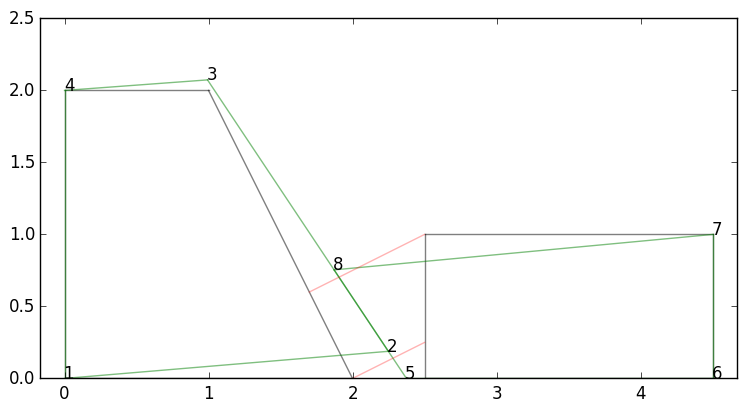

In [4]:
field_problem, boundary_problem_1, boundary_problem_2, boundary_problem_3 = get_test_problem_1()
solver = Solver("solve block problem")
push!(solver, field_problem, boundary_problem_1, boundary_problem_2, boundary_problem_3)
#solver.is_linear_system = true
call(solver)
plot_it(field_problem)
plot_segmentation(boundary_problem_3)

In [5]:
@assert isapprox(norm(field_problem.assembly.u), 0.7572029587976579)

INFO: System is overconstrained by 2 dofs.
INFO: Overconstrained_nodes: 1, 6.
INFO: Following dofs already constrained: 2, 12.
INFO: 
INFO: SUMMARY for node id 1 with dofs 1, 2:
INFO: ----- Current constraint -----
INFO: lambda coefficients in C1 matrix are:
INFO: dof 1: ⋯ + 1.0*λ₁ ⋯
INFO: dof 2: ⋯ + 1.0*λ₂ ⋯
INFO: rows in constraint matrix C2 & D
INFO: dof 1: 1.0*u₁ = 0.0
INFO: dof 2: 1.0*u₂ = 0.0 <-- overconstrained dof
INFO: ----- New constraint -----
INFO: lambda coefficients in C1 matrix are:
INFO: dof 2: ⋯ + 1.0*λ₂ ⋯
INFO: rows in constraint matrix C2 & D
INFO: dof 2: 1.0*u₂ = 0.0 <-- overconstrained dof
INFO: rank = 1, dofs = 1
INFO: algorithm 1 solved issue? true
INFO: fixed: new setting is
INFO: dof 2: 1.0*u₂ = 0.0
INFO: 
INFO: 
INFO: SUMMARY for node id 6 with dofs 11, 12:
INFO: ----- Current constraint -----
INFO: lambda coefficients in C1 matrix are:
INFO: dof 11: ⋯ + 0.5*λ₁₁ ⋯
INFO: dof 12: ⋯ + 0.5*λ₁₂ ⋯
INFO: rows in constraint matrix C2 & D
INFO: dof 11: 0.5*u₁₁ = 0.0
IN

In [6]:
info(field_problem.elements[1]("displacement", [ 1.0, -1.0], 0.0)')
info(field_problem.elements[2]("displacement", [-1.0, -1.0], 0.0)')

INFO: [0.24895296909147305 0.18847925373355964]
INFO: [-0.12546065165888792 0.0]


### Curved interface

In [7]:
function curved_interface_problem(meshfile="/geometry/2d_curved_interface/MESH_SPARSE.med")

    mesh = parse_aster_med_file(Pkg.dir("JuliaFEM")*meshfile)
    
    field_problem = Problem(Elasticity, "two parts with curved interface", 2)
    field_problem.properties.formulation = :plane_stress

    # field problems
    mapping = Dict(:QU4 => Quad4, :TR3 => Tri3)
    for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
        haskey(mapping, eltype) || continue
        element = mapping[eltype](elcon)
        update!(element, "geometry", mesh["nodes"])
        element["youngs modulus"] = 2880.0
        element["poissons ratio"] = 1/3
        push!(field_problem, element)
    end
    for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
        eltype == :SE2 || continue
        elset == :LOAD || continue
        element = Seg2(elcon)
        update!(element, "geometry", mesh["nodes"])
        update!(element, "displacement traction force 2", -100.0)
        push!(field_problem, element)
    end

    # boundary conditions
    sym13 = Problem(Dirichlet, "SYM13", 2, "displacement")
    sym23 = Problem(Dirichlet, "SYM23", 2, "displacement")

    for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
        eltype == :SE2 || continue
        elset == :SYM13 || continue
        element = Seg2(elcon)
        update!(element, "geometry", mesh["nodes"])
        push!(sym13, element)
    end
    for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
        eltype == :SE2 || continue
        elset == :SYM23 || continue
        element = Seg2(elcon)
        update!(element, "geometry", mesh["nodes"])
        push!(sym23, element)
    end

    update!(get_elements(sym13), "displacement 2", 0.0)
    update!(get_elements(sym23), "displacement 1", 0.0)

    info("created $(length(get_elements(field_problem))) field elements.")
#    info("created $(length(get_elements(boundary_problem))) boundary elements.")

    slave_surface = :UPPER_TO_LOWER
    master_surface = :LOWER_TO_UPPER

    contact = Problem(Mortar, "tie contact between blocks", 2, "displacement")
    master_elements = Element[]
    for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
        eltype == :SE2 || continue
        elset == master_surface || continue
        element = Seg2(elcon)
        update!(element, "geometry", mesh["nodes"])
        push!(master_elements, element)
        push!(contact, element)
    end

    first = true
    slave_elements = Element[]
    for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
        eltype == :SE2 || continue
        elset == slave_surface || continue
        element = Seg2(elcon)
        update!(element, "geometry", mesh["nodes"])
        element["master elements"] = master_elements
        push!(slave_elements, element)
        push!(contact, element)
    end
    calculate_normal_tangential_coordinates!(slave_elements, 0.0)
    if first
        element = slave_elements[1]
        Q = element("normal-tangential coordinates", [0.0], 0.0)
        X = element("geometry", [0.0], 0.0)
        info("slave element $slave_surface: midpoint = $X, nt coordinate = $Q")
        first = false
    end

    info("# of master elements: $(length(master_elements))")
    info("# of slave elements: $(length(slave_elements))")

    return field_problem, sym13, sym23, contact

end

field_problem, sym13, sym23, contact = curved_interface_problem()
solver = Solver("solver curved interface")

push!(solver, field_problem, sym13, sym23, contact)

#solver.is_linear_system = true
call(solver)

INFO: Found 5 element sets: SYM23, LOWER_TO_UPPER, LOAD, SYM13, UPPER_TO_LOWER
INFO: created 170 field elements.
INFO: slave element UPPER_TO_LOWER: midpoint = [0.4147584594687138,0.40581289439367096], nt coordinate = [0.06698025853929859 -0.995493336386047
 0.995493336386047 0.06698025853929859]
INFO: # of master elements: 5
INFO: # of slave elements: 6
INFO: solving linear system of 4 problems.
INFO: System is overconstrained by 1 dofs.


true

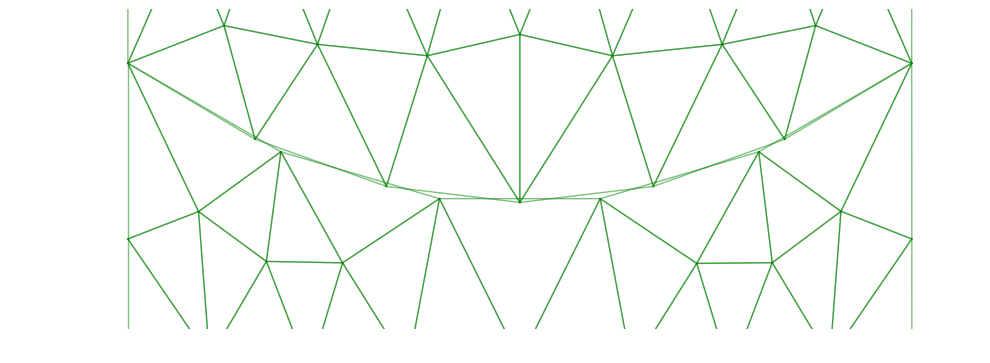

(-0.1,1.1,0.3,0.52)

INFO: Overconstrained_nodes: 47.
INFO: Following dofs already constrained: 93.
INFO: 
INFO: SUMMARY for node id 47 with dofs 93, 94:
INFO: ----- Current constraint -----
INFO: lambda coefficients in C1 matrix are:
INFO: dof 93: ⋯ + 0.062*λ₉₃ ⋯
INFO: rows in constraint matrix C2 & D
INFO: dof 93: 0.062*u₉₃ = 0.0 <-- overconstrained dof
INFO: ----- New constraint -----
INFO: lambda coefficients in C1 matrix are:
INFO: dof 93: ⋯ + 0.085*λ₉₃ ⋯
INFO: dof 94: ⋯ + 0.085*λ₉₄ ⋯
INFO: rows in constraint matrix C2 & D
INFO: dof 93: 0.027*u₉ - 0.081*u₁₀ - 0.0*u₁₁ - 0.0*u₁₂ + 0.027*u₉₃ + 0.081*u₉₄ = 0.0 <-- overconstrained dof
INFO: dof 94: 0.081*u₉ - 0.027*u₁₀ + 0.0*u₁₁ - 0.0*u₁₂ - 0.081*u₉₃ + 0.027*u₉₄ = -0.0
INFO: ----- Related equations -----
INFO: dof 94: 0.081*u₉ - 0.027*u₁₀ + 0.0*u₁₁ - 0.0*u₁₂ - 0.081*u₉₃ + 0.027*u₉₄ = -0.0
INFO: dof 9: 0.062*u₉ = 0.0
INFO: algorithm 1 solved issue? false
INFO: algorithm 2 solved issue? true
INFO: fixed: new setting is
INFO: dof 93: 0.027*u₉ - 0.081*u₁₀ - 0.

In [8]:
figure(figsize=(12, 4))
plot_it(field_problem; show_undeformed=false, equal_axis=false, show_node_ids=false)
xlim(-0.1, 1.1)
ylim(0.30, 0.52)
axis("off")

In [9]:
using JuliaFEM.Preprocess: aster_create_elements

function create_hertzian_problem(meshfile="/geometry/2d_cylinder_roller_contact/MESH_REFINED_3.med")

    mesh = parse_aster_med_file(Pkg.dir("JuliaFEM")*meshfile)
    
    body1 = Problem(Elasticity, "cylinder", 2)
    body1_elements = aster_create_elements(mesh, :CYLINDER, :TR3)
    body1.properties.formulation = :plane_strain
    update!(body1_elements, "youngs modulus", 210e3)
    update!(body1_elements, "poissons ratio", 0.3)
    push!(body1, body1_elements...)

    body2 = Problem(Elasticity, "block", 2)
    body2_elements = aster_create_elements(mesh, :BLOCK, :TR3)
    body2.properties.formulation = :plane_strain
    update!(body2_elements, "youngs modulus", 70.0e3)
    update!(body2_elements, "poissons ratio", 0.3)
    push!(body2, body2_elements...)

    # boundary conditions
    bc1 = Problem(Dirichlet, "ground", 2, "displacement")
    bc1_elements = aster_create_elements(mesh, :GROUND, :SE2)
    update!(bc1_elements, "displacement", 0.0)
    push!(bc1, bc1_elements...)

    bc2 = Problem(Dirichlet, "symmetry line", 2, "displacement")
    bc2_elements = aster_create_elements(mesh, :SYM23, :SE2)
    update!(bc2_elements, "displacement 1", 0.0)
    push!(bc2, bc2_elements...)

    # contact
    bc3 = Problem(Mortar, "contact interface", 2, "displacement")
    bc3_slave_elements = aster_create_elements(mesh, :CYLINDER_TO_BLOCK, :SE2)
    bc3_master_elements = aster_create_elements(mesh, :BLOCK_TO_CYLINDER, :SE2)
    update!(bc3_slave_elements, "master elements", bc3_master_elements)
    calculate_normal_tangential_coordinates!(bc3_slave_elements, 0.0)
    push!(bc3, bc3_slave_elements...)
    push!(bc3, bc3_master_elements...)
    info("# of master elements: $(length(bc3_master_elements))")
    info("# of slave elements: $(length(bc3_slave_elements))")
    fel = bc3_slave_elements[1]
    n = fel("normals", [0.0], 0.0)
    X1 = fel("geometry", [-1.0], 0.0)
    X2 = fel("geometry", [ 1.0], 0.0)
    info("normal direction of first contact element: $n")
    info("element geometry: from $X1 to $X2")

    return body1, body2, bc1, bc2, bc3

end
create_hertzian_problem();

INFO: Found 6 element sets: SYM23, BLOCK_TO_CYLINDER, CYLINDER_TO_BLOCK, CYLINDER, GROUND, BLOCK
INFO: # of master elements: 27


In [10]:
import JuliaFEM.Core: boundary_assembly_posthook!, field_assembly_posthook!

""" Hack y direction nodal force. """
function field_assembly_posthook!(solver::Solver, K::SparseMatrixCSC, f::SparseMatrixCSC)
    info("Hacking nodal force.")
    f[2*(450-1)+2] = -35.0e3/2
end

body1, body2, bc1, bc2, bc3 = create_hertzian_problem()
solver = Solver("roller contact")
#solver.is_linear_system = true
solver.nonlinear_system_max_iterations = 20
bc3.properties.inequality_constraints = true
#bc3.properties.normal_condition = :Contact
#bc3.properties.tangential_condition = :Slip
push!(solver, body1, body2, bc1, bc2, bc3)
solver()

INFO: # of slave elements: 37
INFO: normal direction of first contact element: [0.33004993336440486,-0.9438504633679171]
INFO: element geometry: from [17.19187882421571,203.04854312703935] to [15.811388300842912,202.56583509747463]
INFO: Found 6 element sets: SYM23, BLOCK_TO_CYLINDER, CYLINDER_TO_BLOCK, CYLINDER, GROUND, BLOCK
INFO: # of master elements: 27
INFO: # of slave elements: 37
INFO: normal direction of first contact element: [0.33004993336440486,-0.9438504633679171]
INFO: element geometry: from [17.19187882421571,203.04854312703935] to [15.811388300842912,202.56583509747463]
INFO: solving linear system of 5 problems.
INFO: Hacking nodal force.
INFO: System is overconstrained by 1 dofs.
INFO: Overconstrained_nodes: 11.
INFO: Following dofs already constrained: 21.
INFO: 
INFO: SUMMARY for node id 11 with dofs 21, 22:
INFO: ----- Current constraint -----
INFO: lambda coefficients in C1 matrix are:
INFO: dof 21: ⋯ + 5.0*λ₂₁ ⋯
INFO: dof 22: ⋯ + 5.0*λ₂₂ ⋯
INFO: rows in constraint 

true

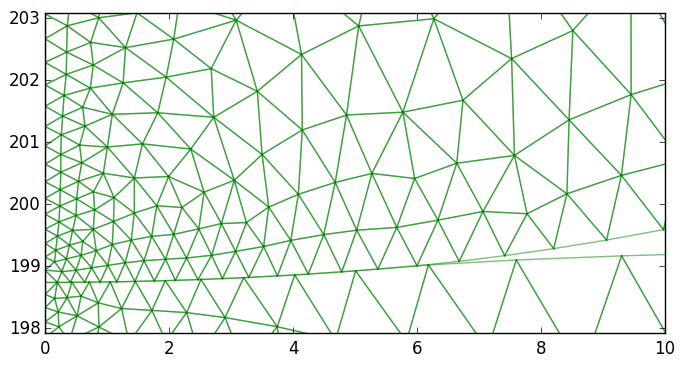

(199,202)

INFO: System is overconstrained by 1 dofs.
INFO: Overconstrained_nodes: 11.
INFO: Following dofs already constrained: 21.
INFO: 
INFO: SUMMARY for node id 11 with dofs 21, 22:
INFO: ----- Current constraint -----
INFO: lambda coefficients in C1 matrix are:
INFO: dof 21: ⋯ + 5.0*λ₂₁ ⋯
INFO: dof 22: ⋯ + 5.0*λ₂₂ ⋯
INFO: rows in constraint matrix C2 & D
INFO: dof 21: 5.0*u₂₁ = 0.0 <-- overconstrained dof
INFO: dof 22: 5.0*u₂₂ = 0.0
INFO: ----- New constraint -----
INFO: lambda coefficients in C1 matrix are:
INFO: dof 21: ⋯ + 5.0*λ₂₁ ⋯
INFO: rows in constraint matrix C2 & D
INFO: dof 21: 5.0*u₂₁ = 0.0 <-- overconstrained dof
INFO: rank = 1, dofs = 1
INFO: algorithm 1 solved issue? true
INFO: fixed: new setting is
INFO: dof 21: 1.0*u₂₁ = 0.0
INFO: 
INFO: PDASS: Starting primal-dual active set strategy to determine active constraints
INFO: PDASS: contact nodes: [490,491,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,

In [11]:
fig = PyPlot.figure(figsize=(8,4))
plot_it(body1, 1.0; show_node_ids=false, show_undeformed=false,
        show_deformed=true, xmin=-1, xmax=30, ymin=190, ymax=210)
plot_it(body2, 1.0; show_node_ids=false, show_undeformed=false,
        show_deformed=true, xmin=-1, xmax=30, ymin=190, ymax=210)
#plot_normals(bc3, 0.0, 1)
#grid("off")
#axis("off")
xlim(0, 10)
ylim(199, 202)
#legend(loc=2)


In [15]:
@assert isapprox(norm(body1.assembly.u), 45.34459038168802)

pmax = 3585.362230884501


INFO: pn[1] = 3662.35094080636


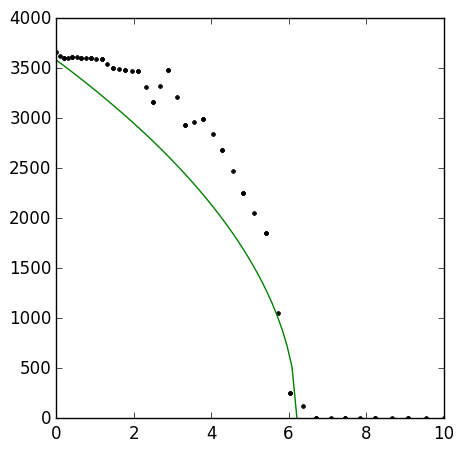

(0,10)

In [13]:
function get_acc_sol()
    B = 1
    E1 = 210.0e3
    E2 = 70.0e3
    nu1 = 0.3
    nu2 = 0.3
    F = 35.0e3
    E = 2*E1*E2/(E2*(1-nu1^2) + E1*(1-nu2^2))
    R = 50.0
    pmax = sqrt(F*E/(2*pi*B*R))
    println("pmax = $pmax")
    a = sqrt(8*F*R/(pi*B*E))
    acc_x = linspace(1.0e-10, a)
    acc_p = pmax*sqrt(1-acc_x/a)
    return acc_x, acc_p
end
acc_x, acc_p = get_acc_sol()

x = Float64[]
pn = Float64[]
#xi = linspace(-1, 1, 5)
xi = [-1.0, 0.0, 1.0]

for element in get_elements(bc3)
    haskey(element, "master elements") || continue
    for k in xi
        X = element("geometry", [k], 0.0)
        u = element("displacement", [k], 0.0)
        pxy = element("reaction force", [k], 0.0)
        Q = element("normal-tangential coordinates", [k], 0.0)
        pnt = Q'*pxy
        push!(x, X[1])
        push!(pn, pnt[1])
        #plot(X[1], pnt[1], "bo")
    end
end

P = sortperm(x)
figure(figsize=(5, 5))
x = x[P]
pn = pn[P]
info("pn[1] = $(pn[1])")
plot(x, pn, "k.")
plot(acc_x, acc_p, "-g")
#    plot(X[1], pxy[1], "ro", label="x direction")
#    plot(X[1], pxy[2], "go", label="y direction")
#    plot(X[1], pnt[2], "bo", label="tangential direction")
xlim(0, 10)
#ylim(0, 4200)
#legend()

In [14]:
minimum(bc3.assembly.la), maximum(bc3.assembly.la)

(-8378.501456957838,671.4667011944753)